In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path

from bart_representation_analysis import *
from bart_compress_visualize_decode import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

# Generate indexes for agent checkpoints

On how long to reach 275 performance
- Showing reward info speeds up training
- Increased p slightly improves learning (although 1.5-1.7 seem more optimal than 2)

In [2]:
# Generate best agent indexes for later analysis

res = pickle.load(open('data/meta_representation_results', 'rb'))
all_rew = res['rewards']
best_idxs = all_rew.sum(axis=(5, 6)).argmax(axis=-1)
pickle.dump(best_idxs, open('data/meta_representation_best_idxs', 'wb'))


# Generate agent indexes of first checkpoints to pass 275 requirement
rewsum = all_rew.sum(axis=(5, 6))
first_idxs = np.zeros(rewsum.shape, dtype='int')[:, :, :, :, 0]

minsum = 275 # total reward that 90% of agents achieve
for h in range(2):
    for i in range(4):
        for j in range(5):
            for t in range(3):
                r = rewsum[h, i, j, t]
                if (r > minsum).any():
                    first_idxs[h, i, j, t] = np.argmax(r > minsum)
                else:
                    first_idxs[h, i, j, t] = np.argmax(r)
pickle.dump(first_idxs, open('data/meta_representation_first_idxs', 'wb'))

# Generate agent indexes of checkpoints closest to 275 requirement
close_idxs = np.abs(rewsum - minsum).argmin(axis=-1)
pickle.dump(close_idxs, open('data/meta_representation_close_idxs', 'wb'))

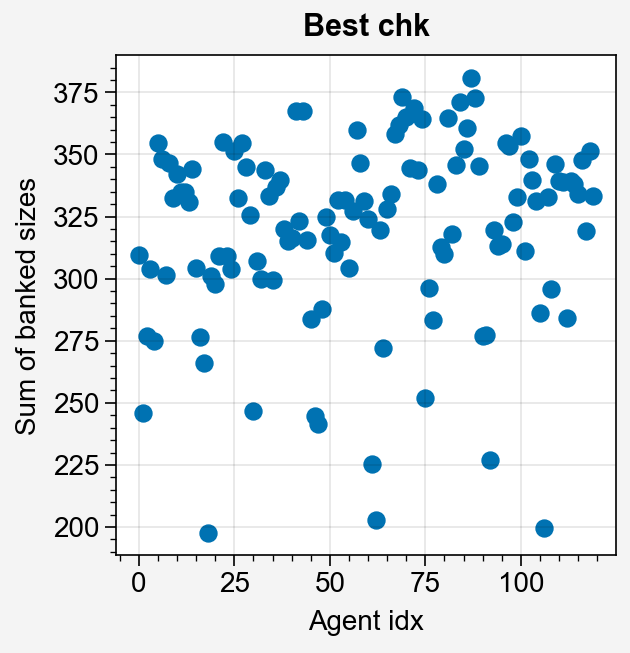

In [14]:
fig, ax = pplt.subplots()
ax[0].scatter(select_idxs(rewsum, 'best').flatten())

ax.format(xlabel='Agent idx', ylabel='Sum of banked sizes', 
          toplabels=['Best chk'])

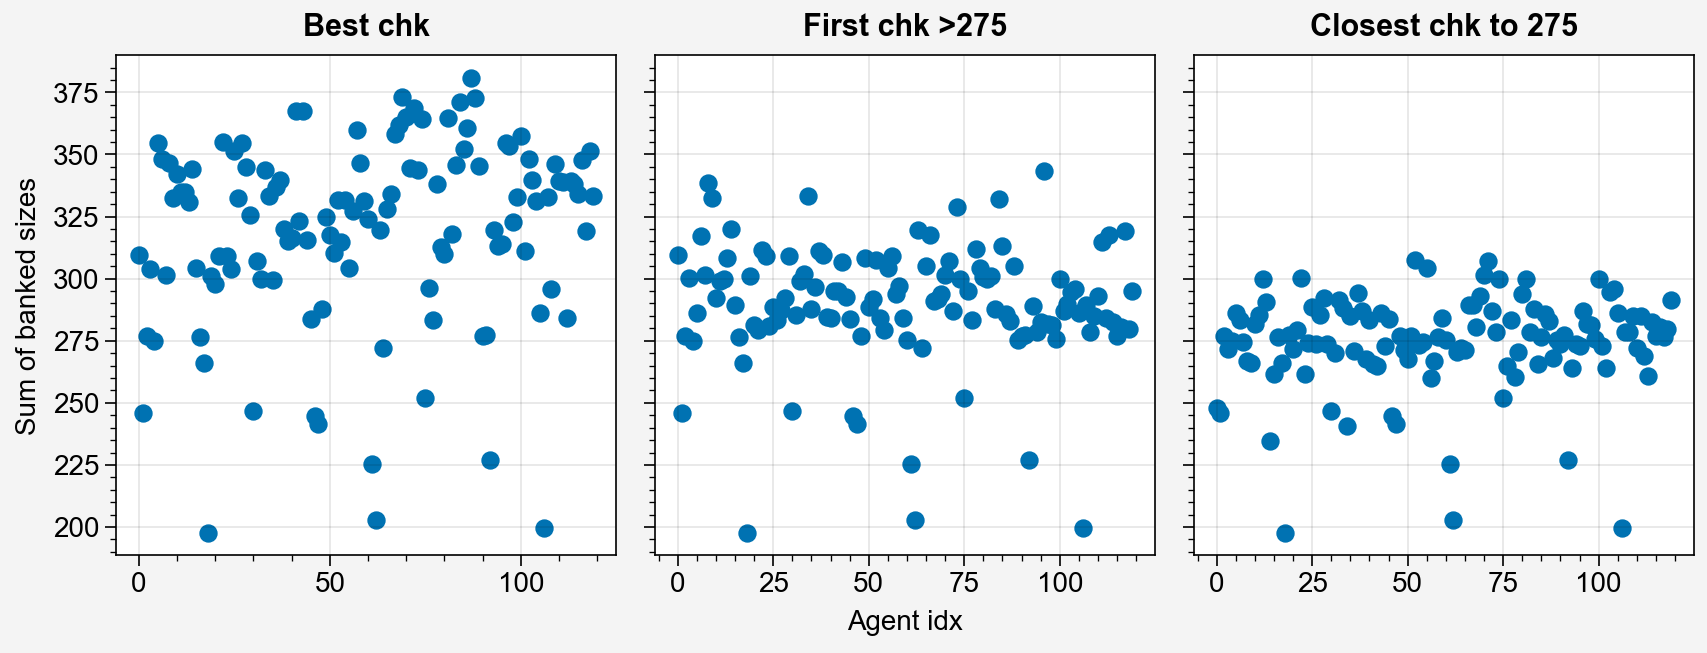

In [70]:
fig, ax = pplt.subplots(ncols=3)
ax[0].scatter(select_idxs(rewsum, best_idxs).flatten())
ax[1].scatter(select_idxs(rewsum, first_idxs).flatten())
ax[2].scatter(select_idxs(rewsum, close_idxs).flatten())

ax.format(xlabel='Agent idx', ylabel='Sum of banked sizes', 
          toplabels=['Best chk', 'First chk >275', 'Closest chk to 275'])

## Time to reach 275

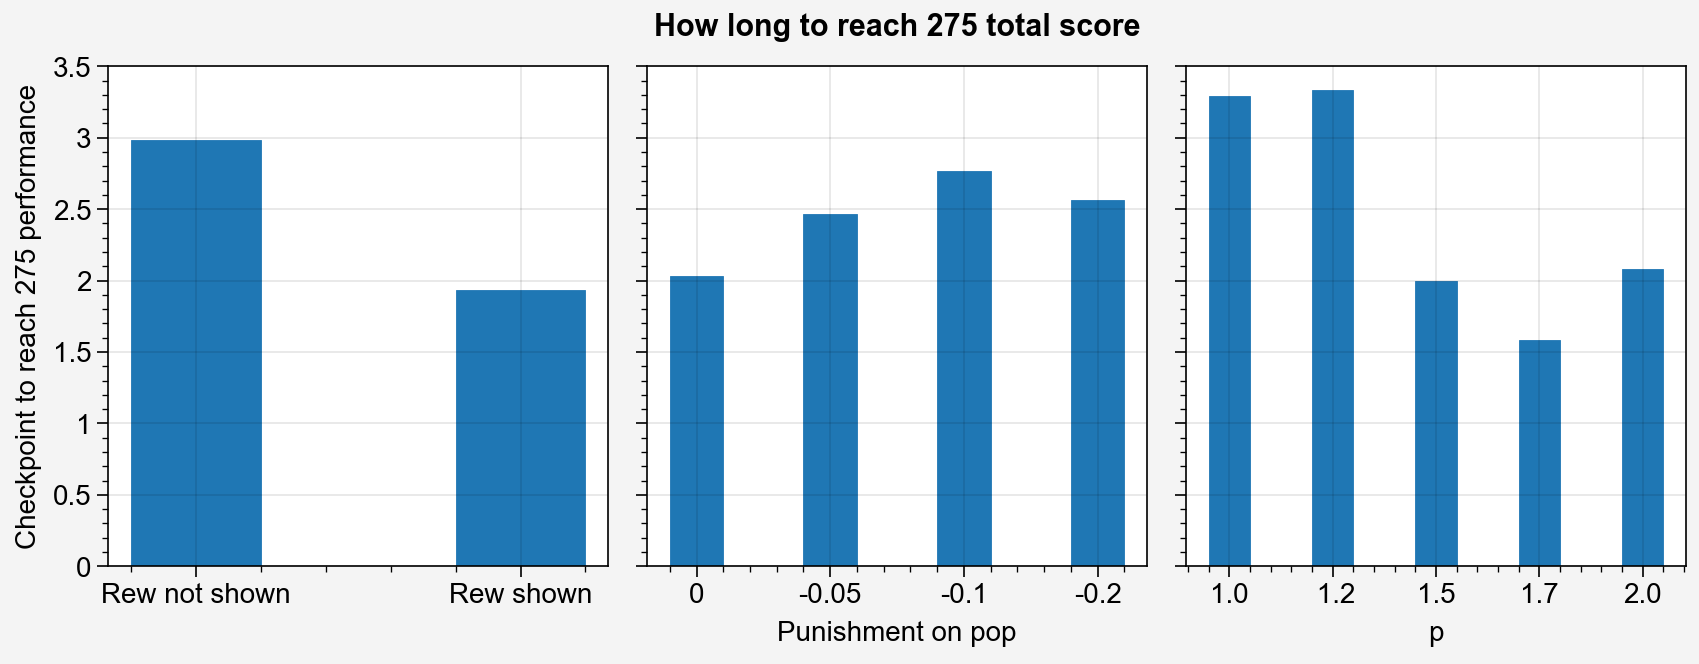

In [12]:
give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
pop_axis = 'Punishment on pop'
p_axis = 'p'

fig, ax = pplt.subplots(ncols=3, sharex=False)
for i in range(2):
    s = len(first_idxs[i].reshape(-1))
    # ax[0].boxplot(i, first_idxs[i].reshape(-1))
    # ax[0].scatter(s*[i], first_idxs[i].reshape(-1))
    ax[0].bar([i], first_idxs[i].reshape(-1).mean(), c=rgb_colors[0])
    ax[0].format(xlocator=range(2), xformatter=give_labels)
for i in range(4):
    s = len(first_idxs[:, i].reshape(-1))
    # ax[1].boxplot(i, first_idxs[:, i].reshape(-1))
    # ax[1].scatter(s*[i], first_idxs[:, i].reshape(-1))
    ax[1].bar([i], first_idxs[:, i].reshape(-1).mean(), c=rgb_colors[0])
    ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis)
for i in range(5):
    s = len(first_idxs[:, :, i].reshape(-1))
    # ax[2].boxplot(i, first_idxs[:, :, i].reshape(-1))
    # ax[2].scatter(s*[i], first_idxs[:, :, i].reshape(-1))
    ax[2].bar([i], first_idxs[:, :, i].reshape(-1).mean(), c=rgb_colors[0])
    ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis)

ax.format(ylabel='Checkpoint to reach 275 performance',
          suptitle='How long to reach 275 total score')

# General performance measures

In [2]:
give_rew = ['', 'giverew_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
chk_labels = [str(c) for c in chks]
chk_axis = 'Checkpoint'
pop_axis = 'Punishment on pop'
p_axis = 'p'

iterators = [give_rew, postfixes, models, trials, chks]
# iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

res = pickle.load(open('data/meta_representation_results', 'rb'))

def metabart_model_load(h, i, j, k, l):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    if h == 1 and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')

    return model, obs_rms

In [5]:
np.array(list(r.keys()))

array(['last_sizes', 'unpopped_sizes', 'pop_rate', 'rewards', 'values',
       'action_probs', 'all_lens', 'all_num_balloons', 'balloon_steps',
       'button_presses', 'dec_flow_scores', 'iterators_idxs', 'sizes',
       'ramp_f1s', 'ramp_indiv_contribs', 'confidence_scores',
       'unconfidence_scores', 'unconfident_points', 'step_count',
       'all_decision_nodes', 'cluster_regressor_coefs',
       'cluster_regressor_scores', 'cluster_ks', 'pca_regressor_coefs',
       'pca_regressor_scores'], dtype='<U24')

# Rewards for best agents

Possible the more accurate version of performance can be found by looking at the best performance reached by each agent across checkpoints. Performance here is measured purely based on the total size of balloons banked, without any $p$ or pop considerations

- No clear trend across punishments on performance
- No significant difference in performance 
- Clear increase to rewards as $p$ increases

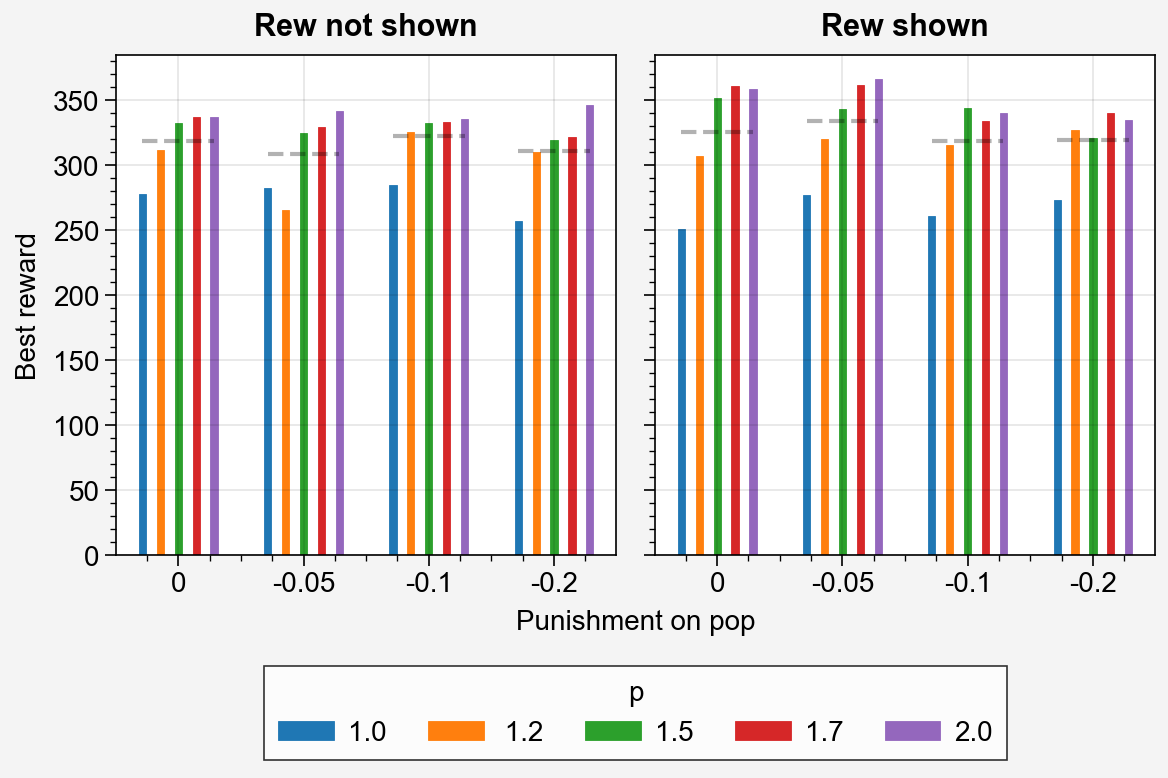

In [140]:
all_rew = res['rewards']
fig, ax = pplt.subplots(ncols=2)

for h in range(2):
    for i in range(len(pop_labels)):
        bars = []
        ys = []
        for j in range(len(p_labels)):
            x = i*7+j
            y = all_rew[h, i, j].sum(axis=(2, 3)).max(axis=1).mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[j], label=p_labels[j]))
            ys.append(y)
            
        y = np.mean(ys)
        ax[h].plot([i*7+0, i*7+4], [y, y], c='black', ls='--', alpha=0.3)

ax.format(toplabels=give_labels, xlocator=np.arange(4)*7+2, xformatter=pop_labels,
          xlabel=pop_axis, ylabel='Best reward')
fig.legend(bars, loc='b', ncols=5, title='p')
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

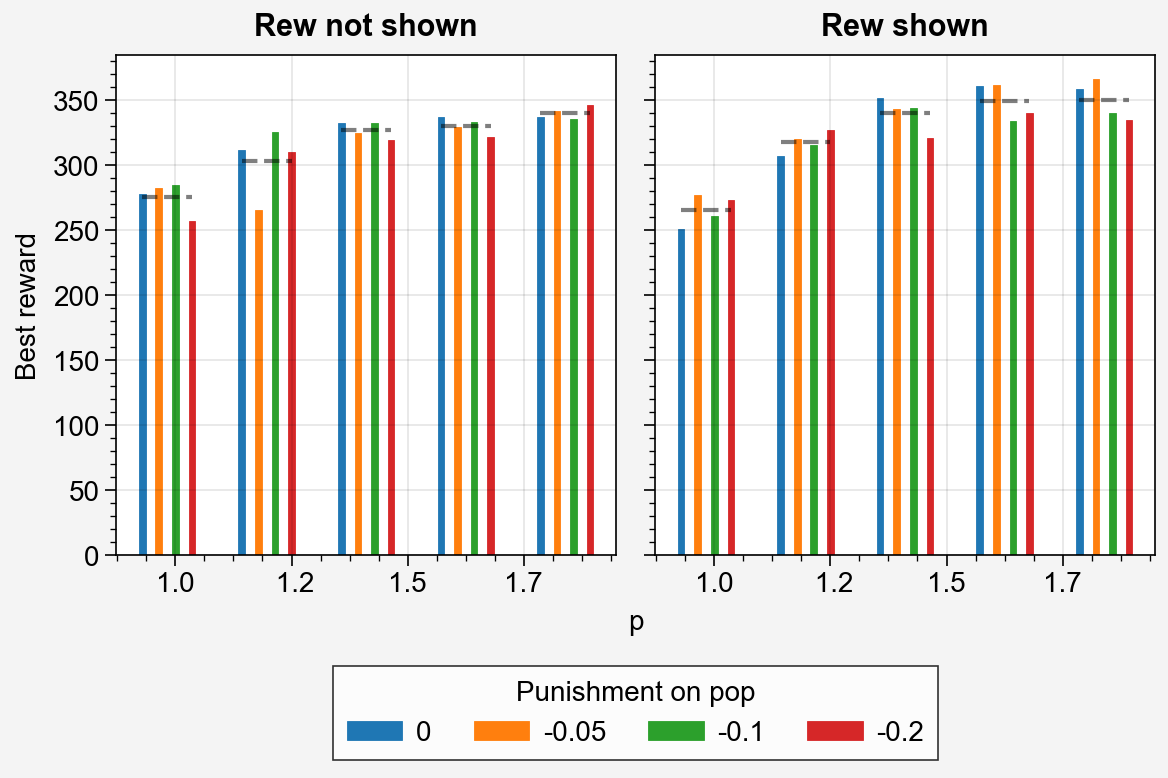

In [159]:
rew = res['rewards'].sum(axis=-1)
rew = rew.sum(axis=-1)

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = all_rew[h, i, j].sum(axis=(2, 3)).max(axis=1).mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)

        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=np.arange(4)*7+2, xformatter=p_labels,
          xlabel=p_axis, ylabel='Best reward')
fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

p-value: 0.1808


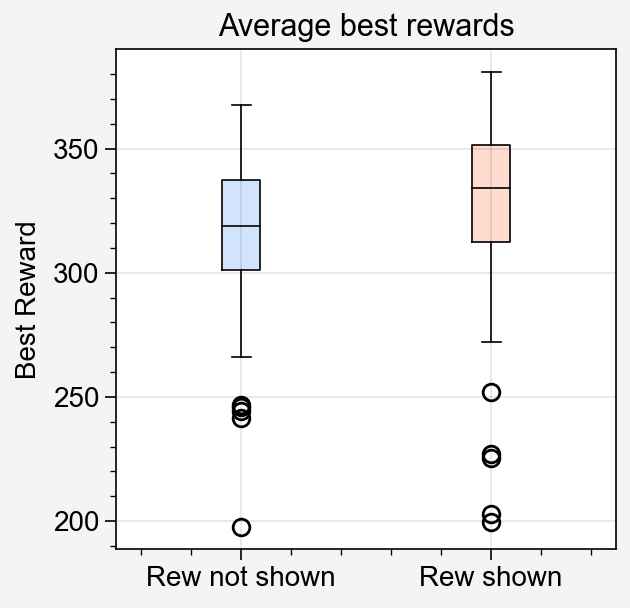

In [155]:
all_rew = res['rewards']
fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = all_rew[h].sum(axis=(4, 5)).max(axis=-1).flatten()
    ax.boxplot(h, y, cycle=rgb_colors[h])
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Best Reward',
          title='Average best rewards')

p-value: 0.5369


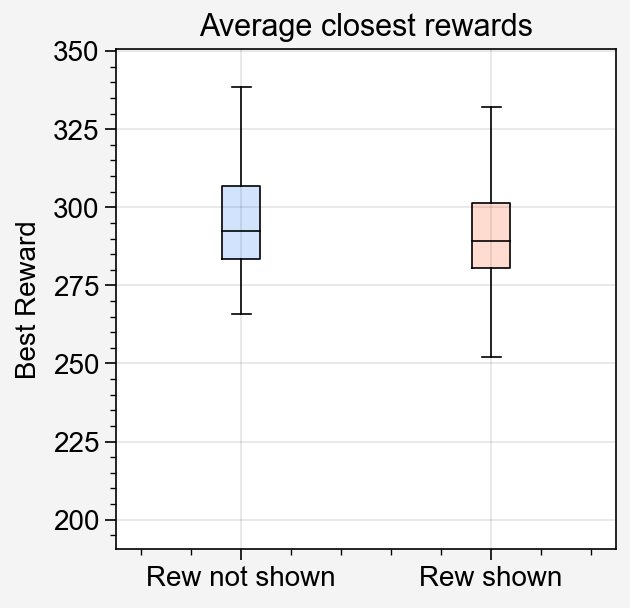

In [21]:
all_rew = res['rewards'].sum(axis=(5, 6))
all_rew = select_idxs(all_rew, 'first')
fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = all_rew[h].reshape(-1)
    ax.boxplot(h, y, cycle=rgb_colors[h], fliers=False)
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Best Reward',
          title='Average closest rewards')

p-value: 0.0027


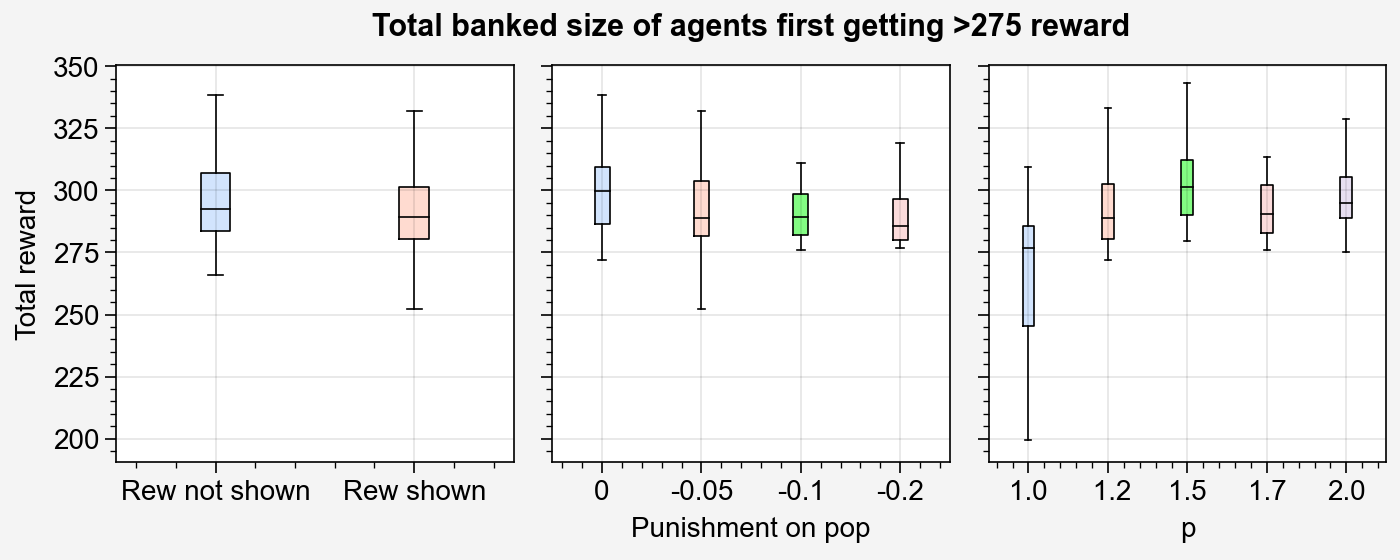

In [37]:
all_rew = res['rewards'].sum(axis=(5, 6))
all_rew = select_idxs(all_rew, 'first')
fig, ax = pplt.subplots(ncols=3, figwidth=7, sharex=False)

ys = []
for h in range(2):
    y = all_rew[h].reshape(-1)
    ax[0].boxplot(h, y, cycle=rgb_colors[h], fliers=False)
    ax[0].format(xlocator=range(2), xformatter=give_labels, ylabel='Total reward')
    ys.append(y)
for i in range(4):
    y = all_rew[:, i].reshape(-1)
    ax[1].boxplot(i, y, cycle=rgb_colors[i], fliers=False)
    ax[1].format(xlocator=range(4), xformatter=pop_labels, xlabel=pop_axis,
                 ylabel='Total reward')
    ys.append(y)
for j in range(5):
    y = all_rew[:, :, j].reshape(-1)
    ax[2].boxplot(j, y, cycle=rgb_colors[j], fliers=False)
    ax[2].format(xlocator=range(5), xformatter=p_labels, xlabel=p_axis,
                 ylabel='Total reward')
    ys.append(y)
    
ax.format(suptitle='Total banked size of agents first getting >275 reward')
print(f'p-value: {ttest_ind(ys[6], ys[7]).pvalue:.4f}')

## Pop rates for best agents

Taking the best agents as we did in the previous section, we can now look at the best agents from each of these. Some more clear trends
- Punishment does not have significant trend effect on pop rate
- Increased $p$ increases pop rates (makes sense, as the agents are incentivized to push balloons larger)
- Showing reward in the observation actually seems to increase pop rate, which may be related to the agents pushing balloons a bit larger when rewards are shown

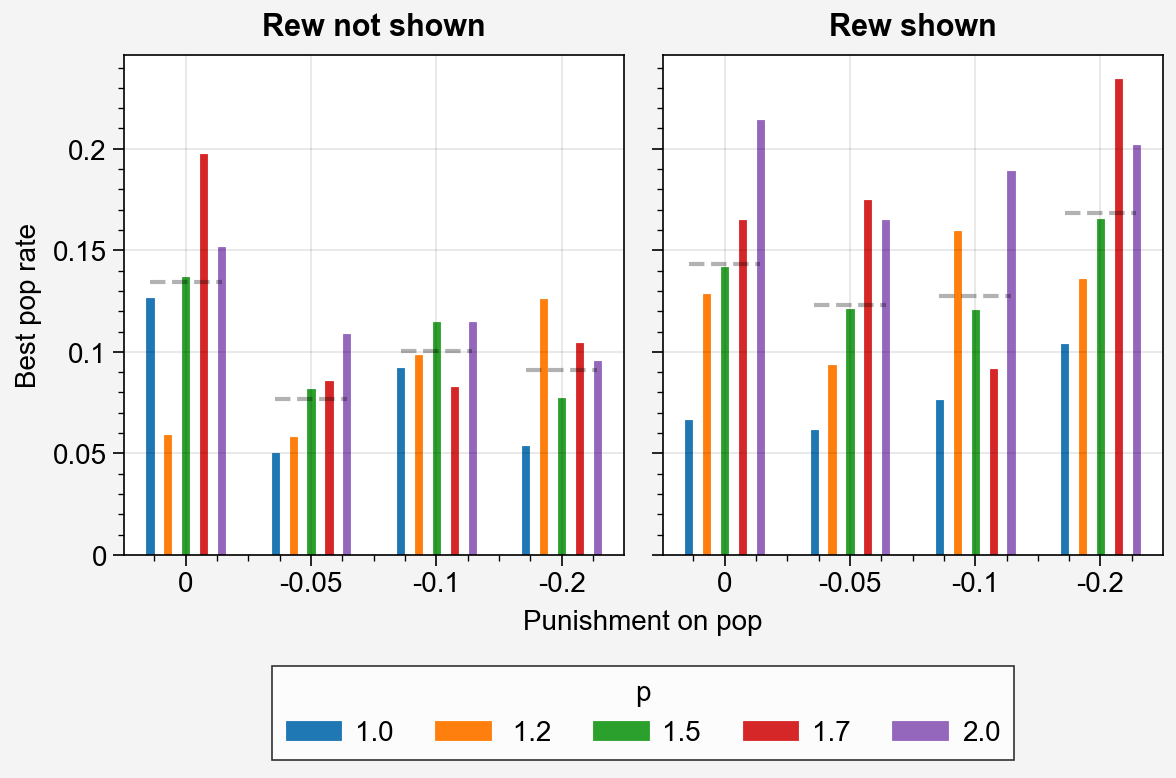

In [14]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates)

fig, ax = pplt.subplots(ncols=2)

for h in range(2):
    for i in range(len(pop_labels)):
        bars = []
        ys = []
        for j in range(len(p_labels)):
            x = i*7+j
            y = pop_rates[h, i, j].mean(axis=-1)
            bars.append(ax[h].bar(x, y, c=rgb_colors[j], label=p_labels[j]))
            ys.append(y)
            
        y = np.mean(ys)
        ax[h].plot([i*7+0, i*7+4], [y, y], c='black', ls='--', alpha=0.3)

ax.format(toplabels=give_labels, xlocator=np.arange(4)*7+2, xformatter=pop_labels,
          xlabel=pop_axis, ylabel='Best pop rate')
fig.legend(bars, loc='b', ncols=5, title='p')
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

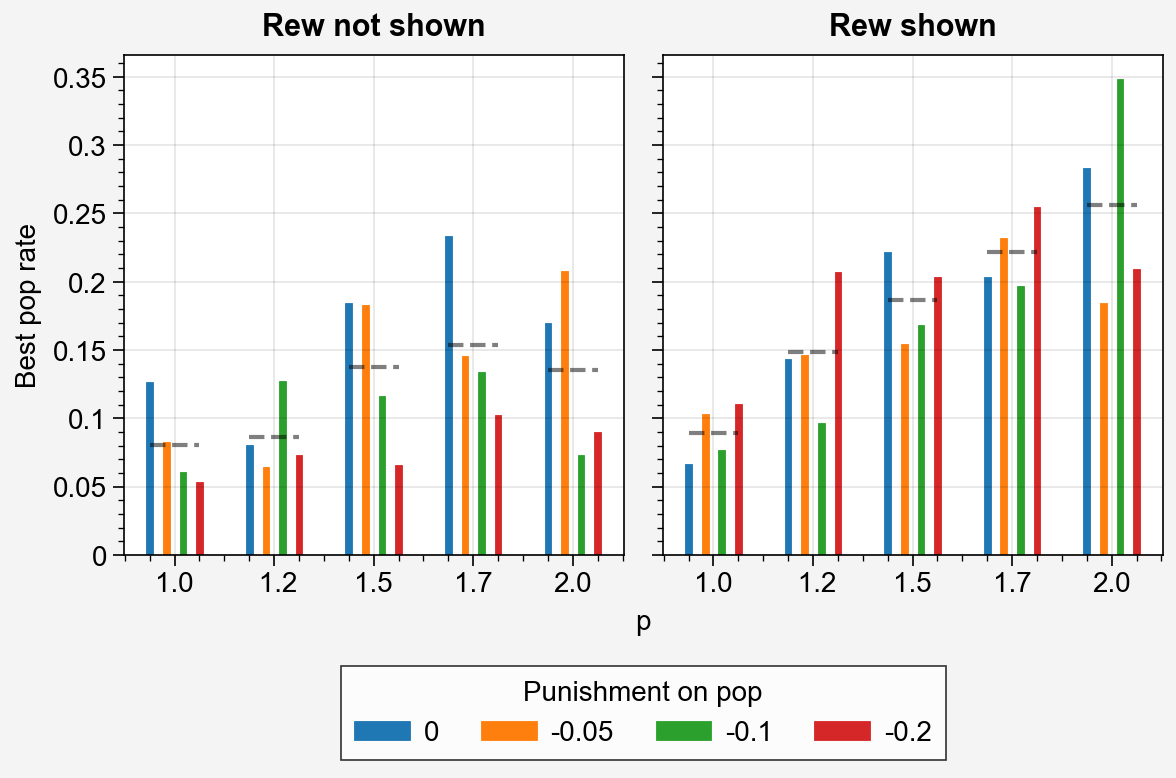

In [15]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = pop_rates[h, i, j].mean(axis=-1)
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)

        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=np.arange(5)*6+1.5, xformatter=p_labels,
          xlabel=p_axis, ylabel='Best pop rate')
fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

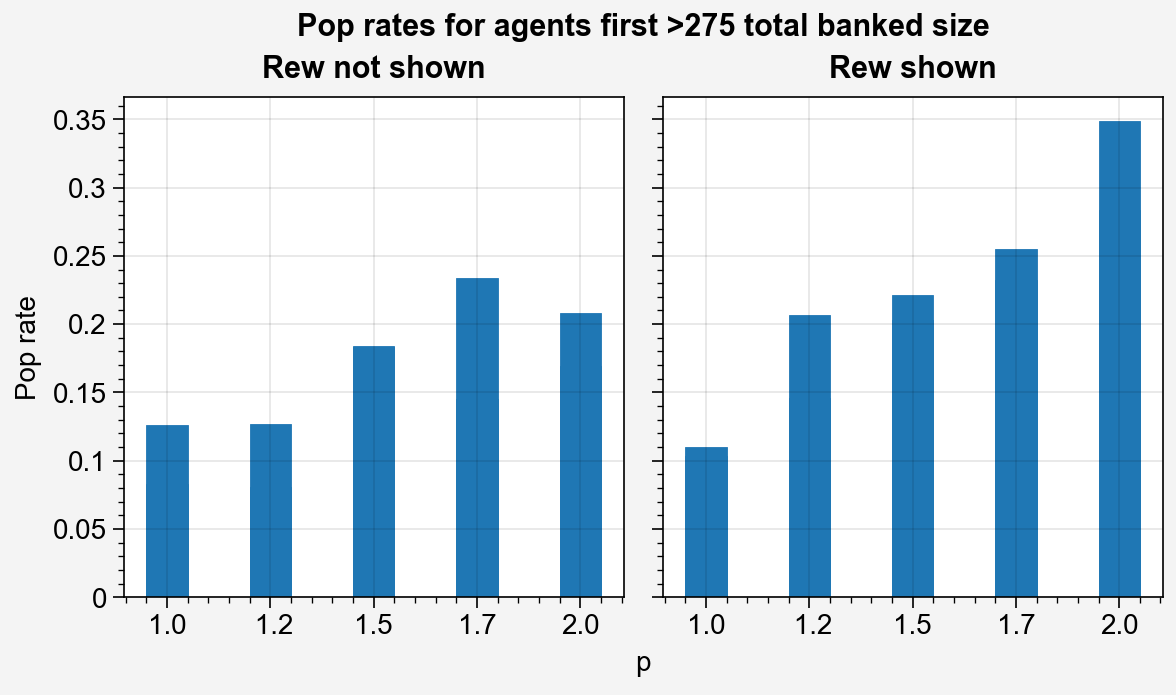

In [39]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    bars = []
    ys = []
    for j in range(len(p_labels)):
        x = j
        y = pop_rates[h, :, j].mean(axis=-1)
        bars.append(ax[h].bar(x, y, c=rgb_colors[0], label=pop_labels[i]))
        ys.append(y)

        y = np.mean(ys)
        # ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=range(5), xformatter=p_labels,
          xlabel=p_axis, ylabel='Pop rate', suptitle='Pop rates for agents first >275 total banked size')
# fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

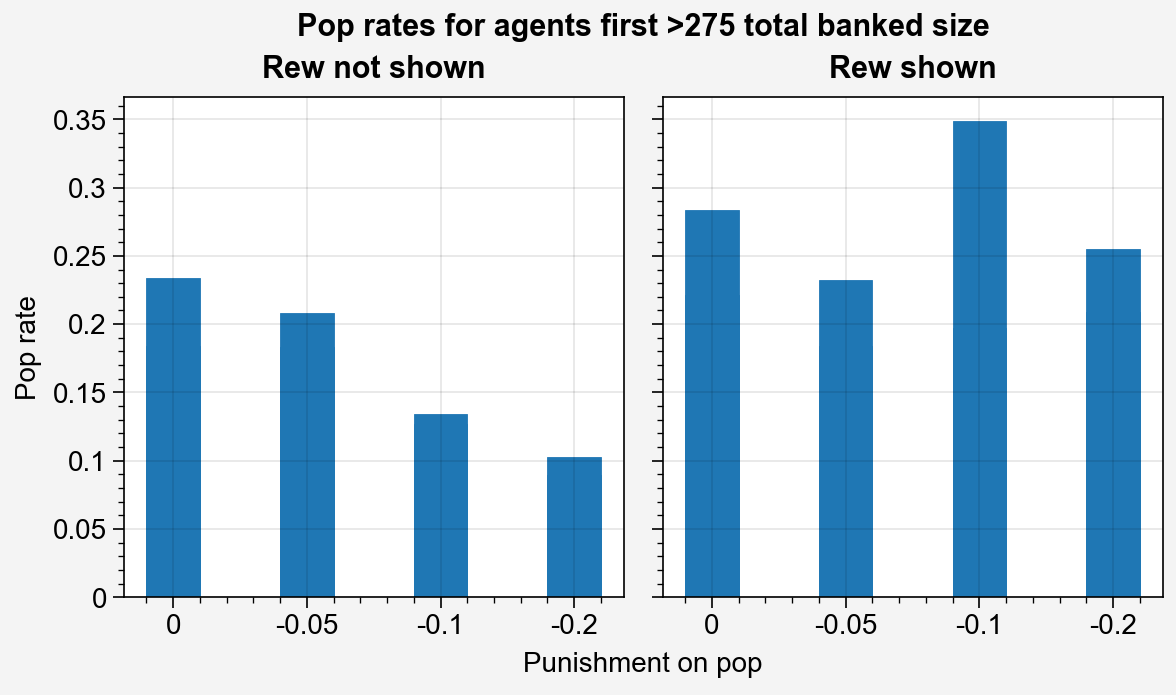

In [40]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots(ncols=2)


for h in range(2):
    bars = []
    ys = []
    for j in range(len(pop_labels)):
        x = j
        y = pop_rates[h, j, :].mean(axis=-1)
        bars.append(ax[h].bar(x, y, c=rgb_colors[0], label=pop_labels[i]))
        ys.append(y)

        y = np.mean(ys)
        # ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
ax.format(toplabels=give_labels, xlocator=range(4), xformatter=pop_labels,
          xlabel=pop_axis, ylabel='Pop rate', suptitle='Pop rates for agents first >275 total banked size')
# fig.legend(bars, loc='b', ncols=5, title=pop_axis)
# ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

p-value: 0.0002


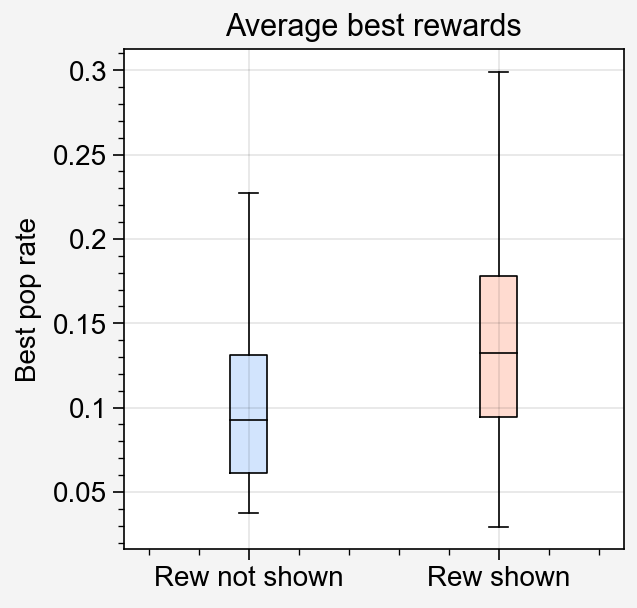

In [21]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates)

fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = pop_rates[h].flatten()
    ax.boxplot(h, y, cycle=rgb_colors[h])
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Best pop rate',
          title='Average best rewards')

p-value: 0.000038


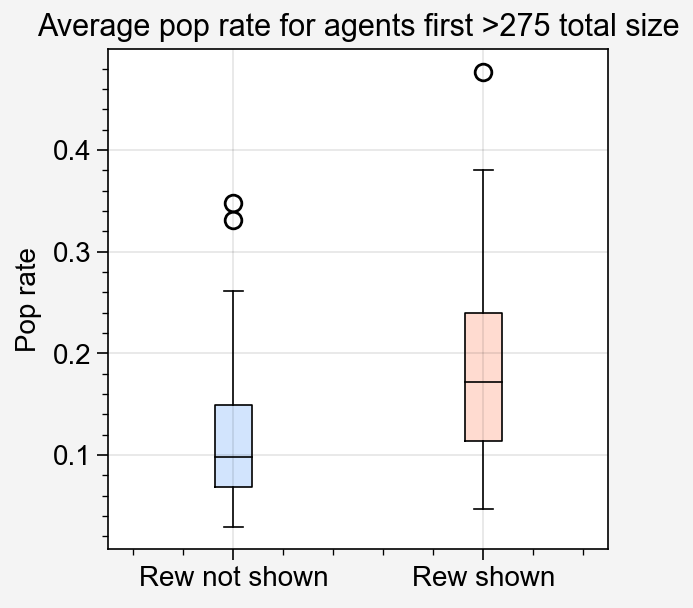

In [43]:
pop_rates = res['pop_rate']
pop_rates = pop_rates.mean(axis=-1)
pop_rates = select_idxs(pop_rates, 'first')

fig, ax = pplt.subplots()

ys = []
for h in range(2):
    y = pop_rates[h].flatten()
    ax.boxplot(h, y, cycle=rgb_colors[h])
    ys.append(y)
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.6f}')
ax.format(xlocator=range(2), xformatter=give_labels, ylabel='Pop rate',
          title='Average pop rate for agents first >275 total size')

# Rewards over training

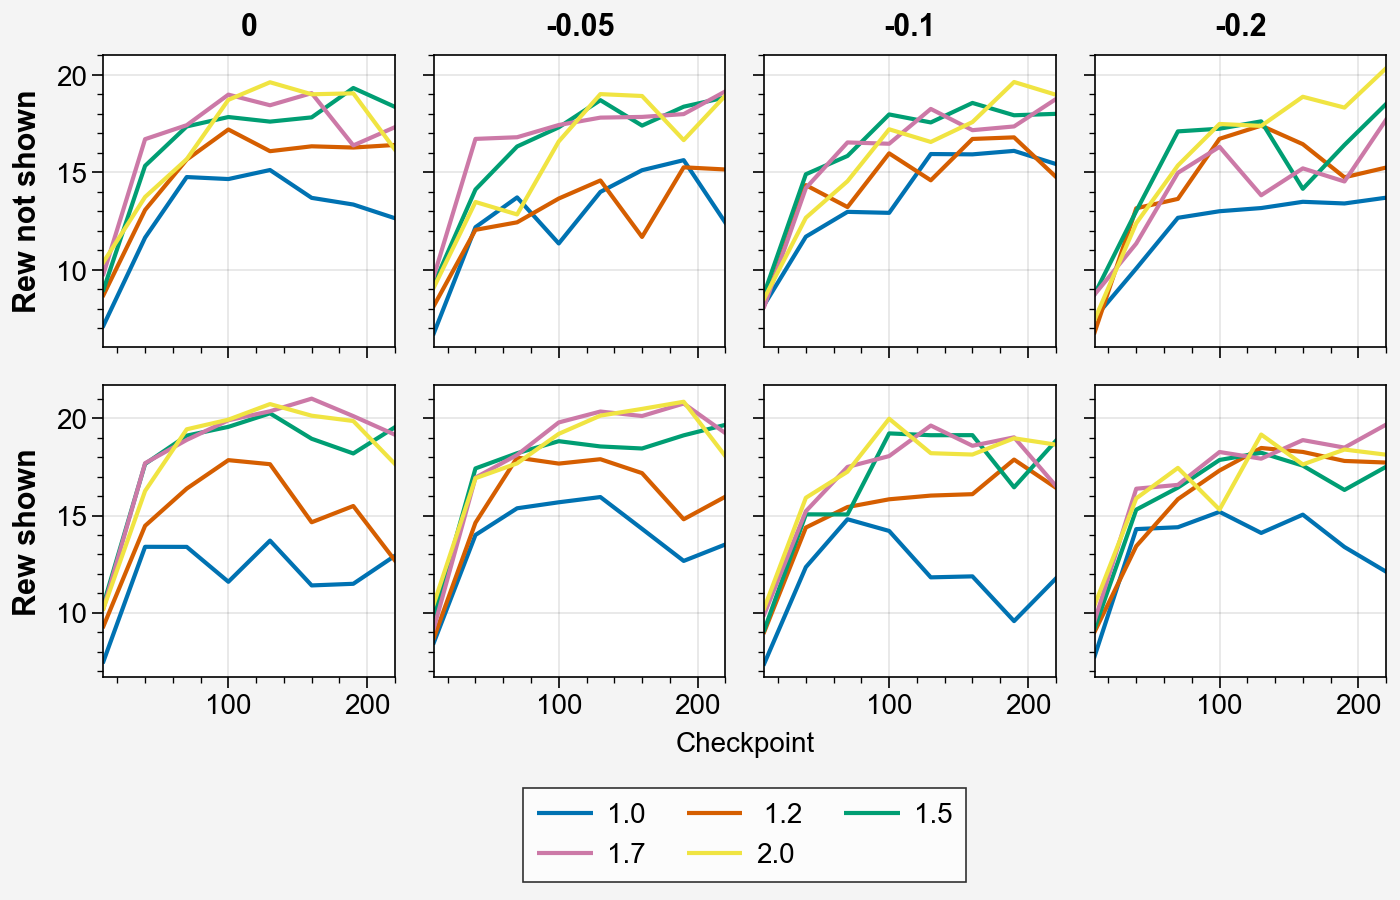

In [28]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=7)

for h in range(len(give_labels)):
    for i in range(len(pop_labels)):
        r = all_rew[h, i].sum(axis=4).mean(axis=(1, 3))
        lines = ax[h, i].plot(chks, r.T, label=p_labels)
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=give_labels)
        

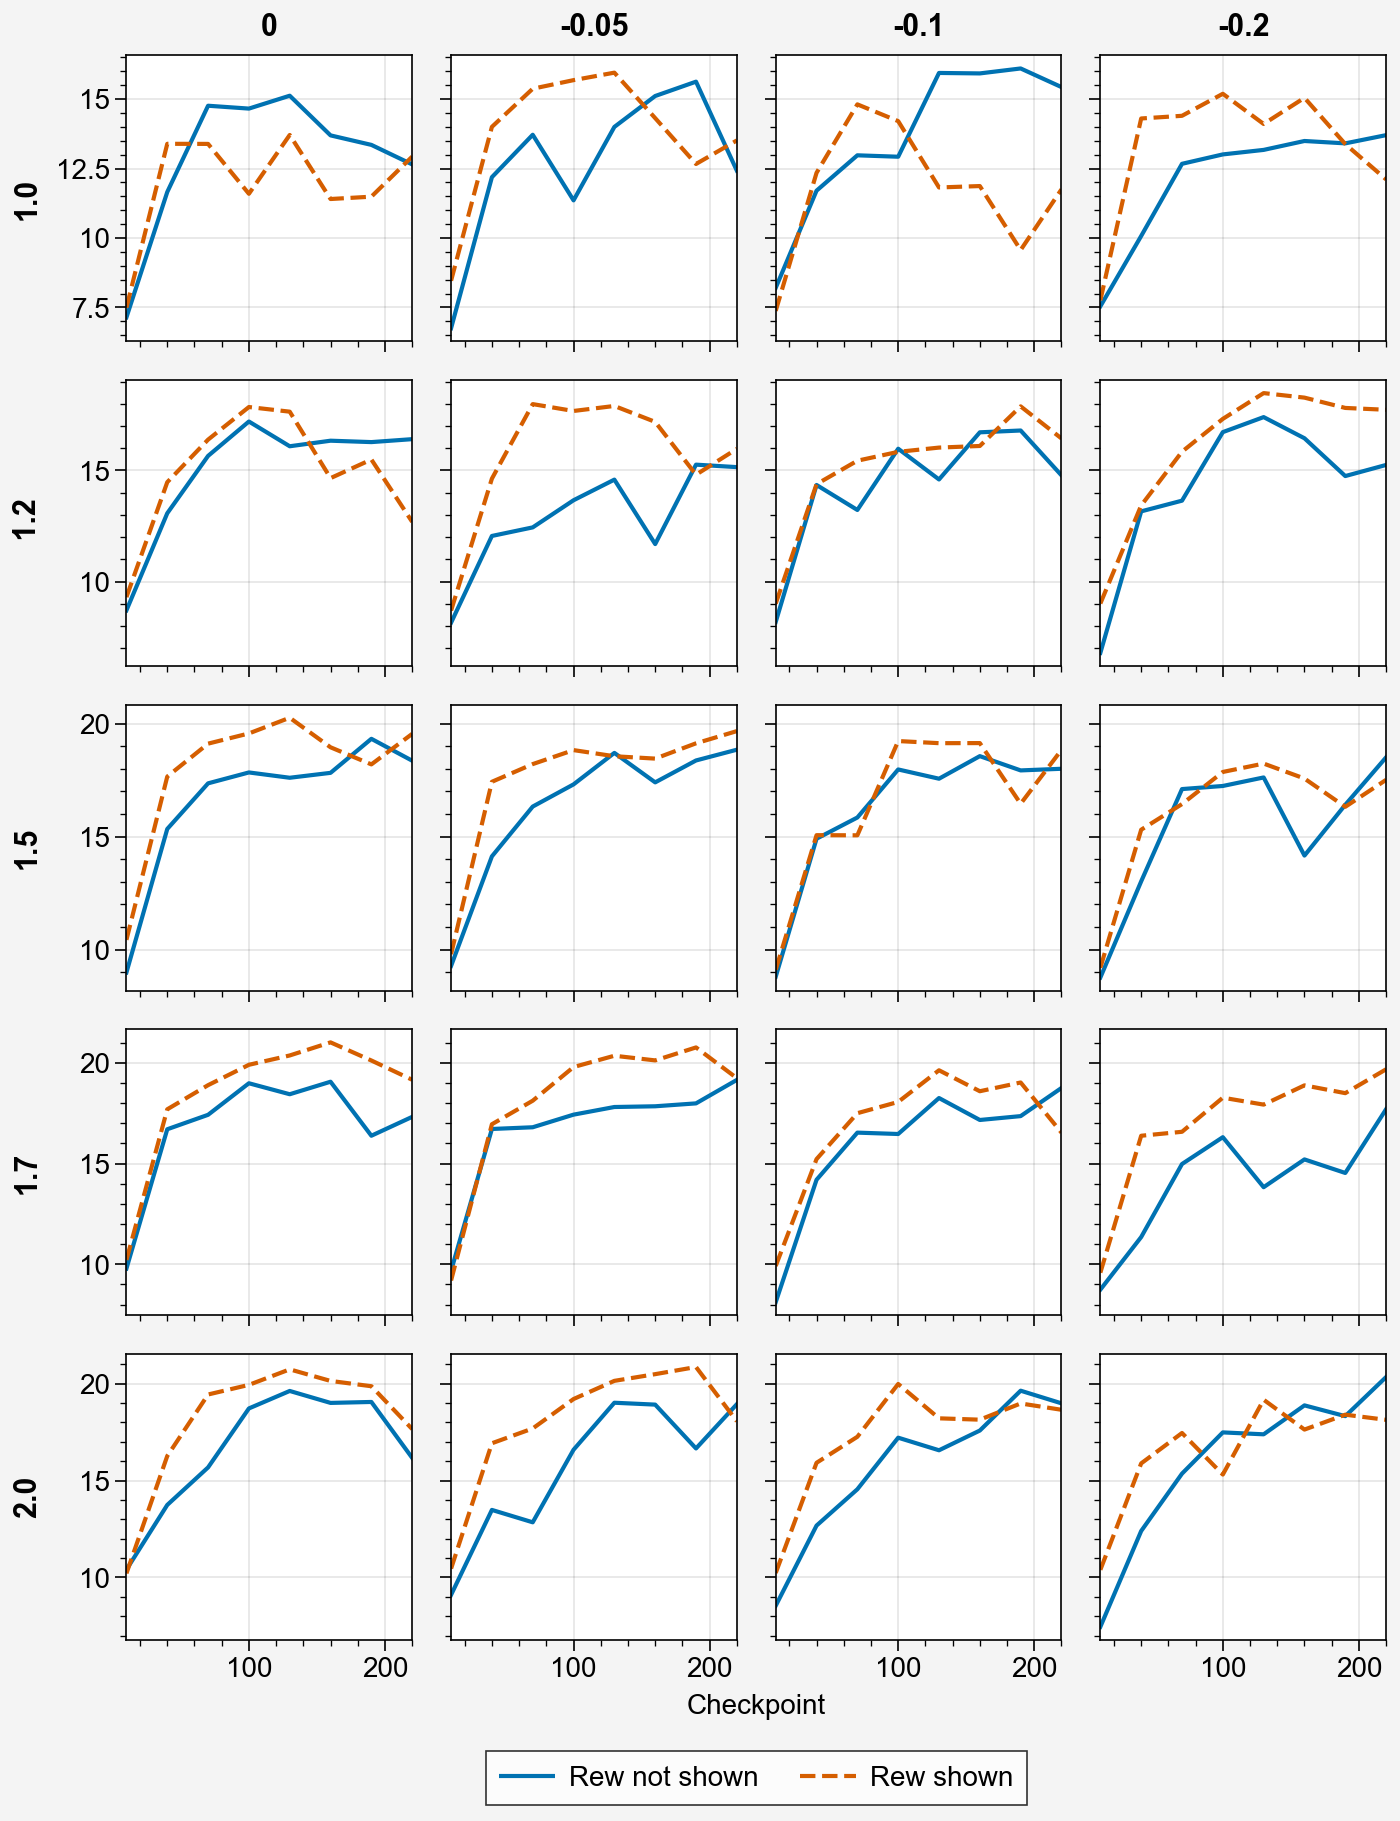

In [30]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = all_rew[:, i, j].sum(axis=4).mean(axis=(1, 3))
        lines = []
        lines.append(ax[j, i].plot(chks, r[0], label=give_labels[0]))
        lines.append(ax[j, i].plot(chks, r[1], label=give_labels[1],
                                   ls='--'))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels)
        

## Pop rates

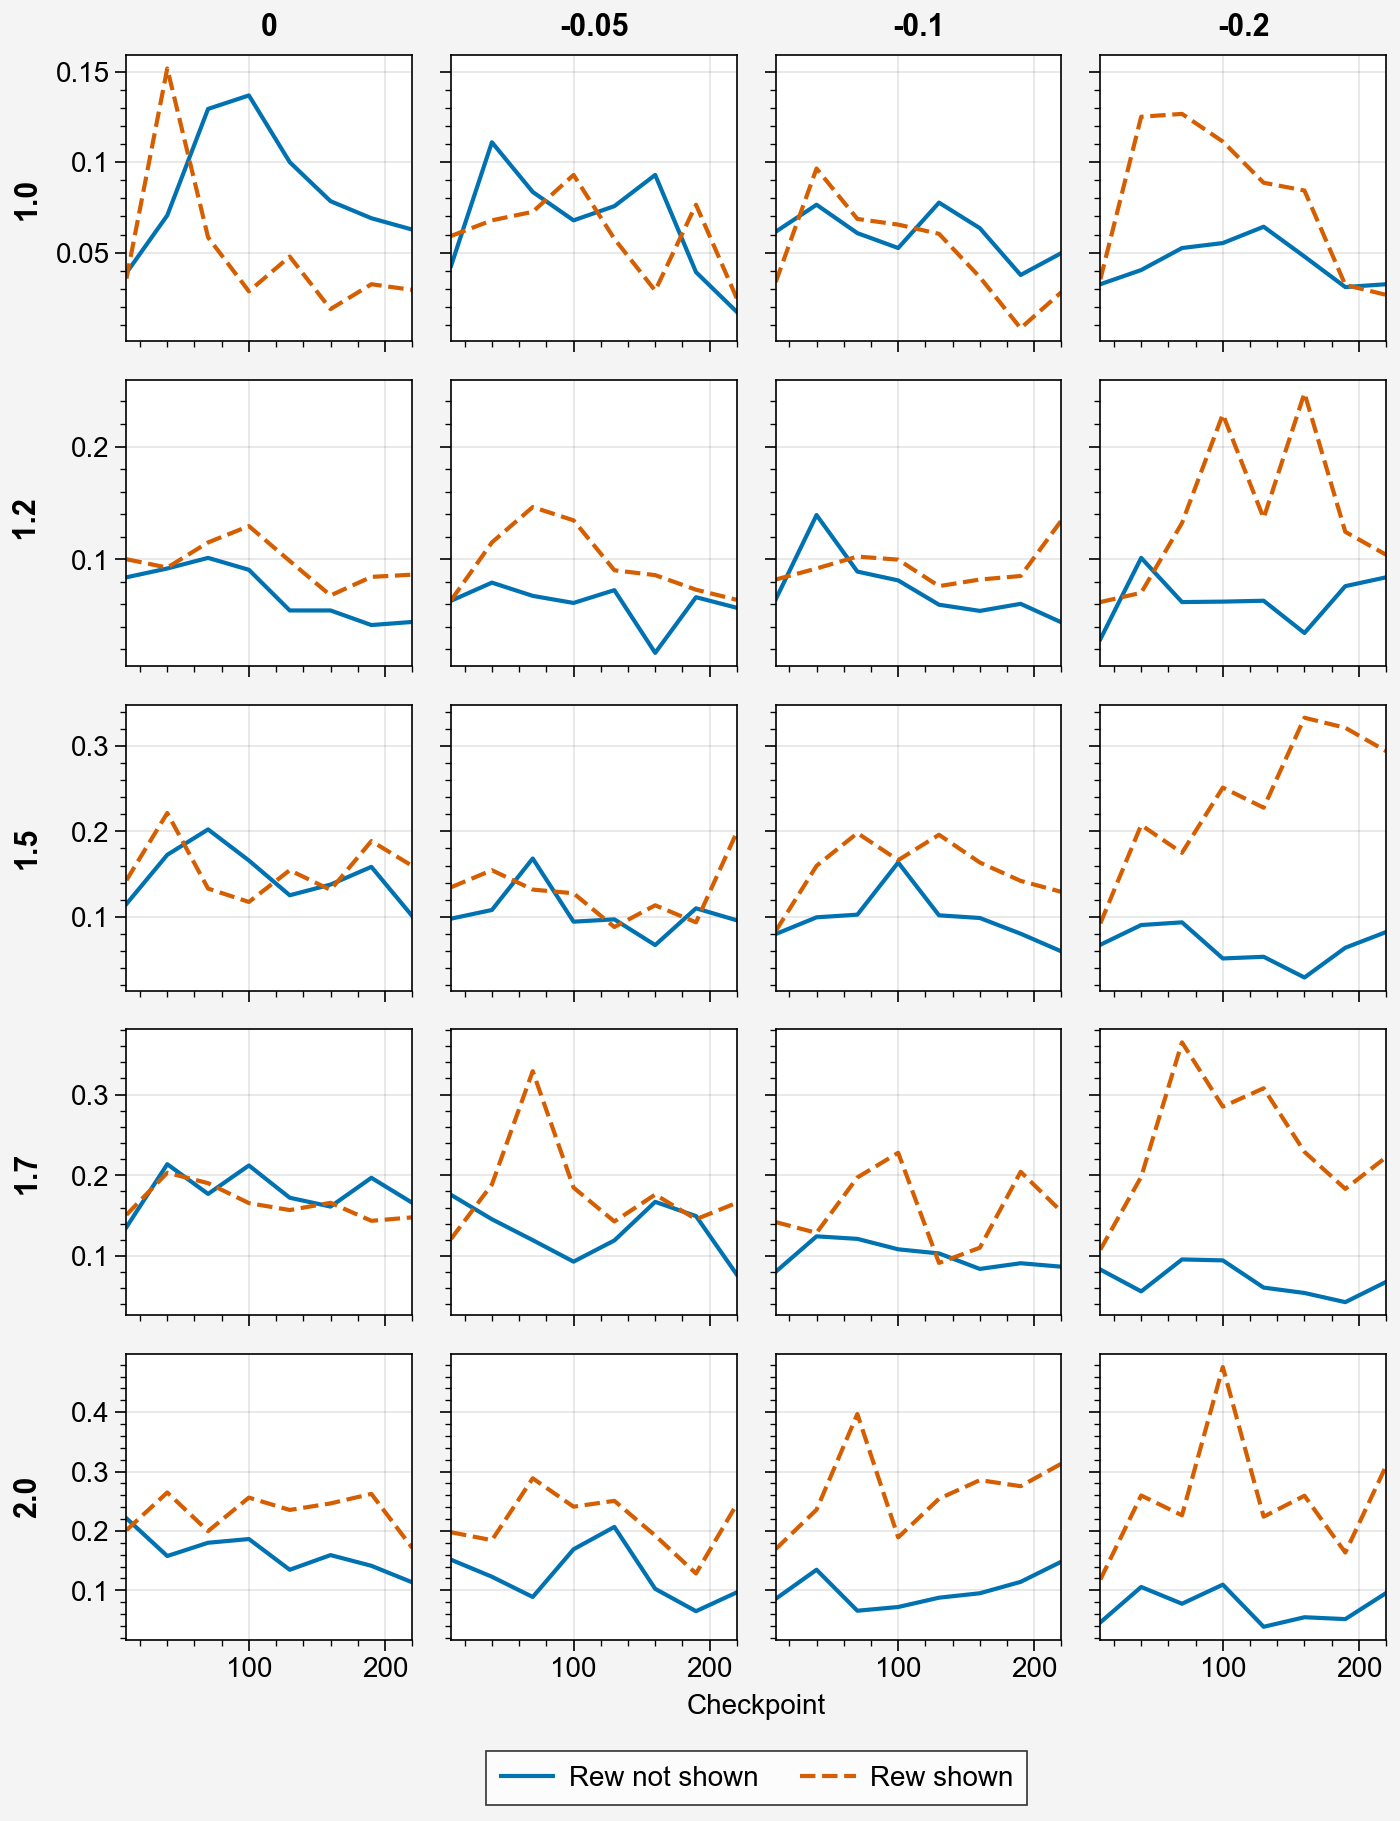

In [66]:
# True rewards

pop_rates = res['pop_rate']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = pop_rates[:, i, j].mean(axis=(1, 3))
        lines = []
        lines.append(ax[j, i].plot(chks, r[0], label=give_labels[0]))
        lines.append(ax[j, i].plot(chks, r[1], label=give_labels[1],
                                   ls='--'))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels)
        

## Variation rewards

The rewards that the agent actually earns under their own training conditions

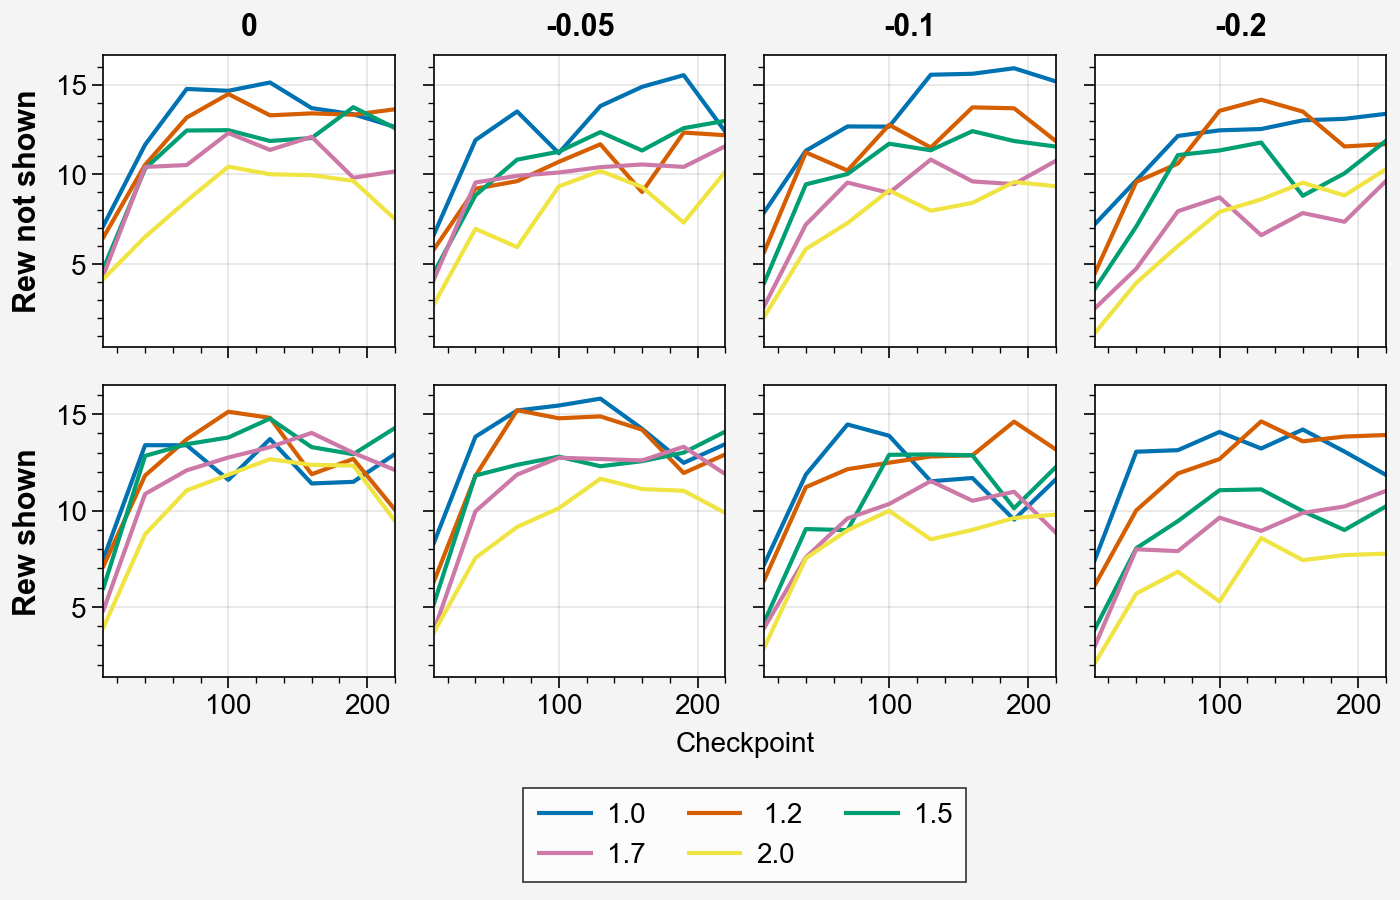

In [67]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']
all_pops = res['pop_rate']
all_num_balloons = res['all_num_balloons']

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=7)

for h in range(len(give_labels)):
    for i in range(len(pop_labels)):
        lines = []
        pun = pop_vals[i]
        for j, p in enumerate(models):
            r = (all_rew[h, i, j]**p).sum(axis=3)
            pop = pop_rates[h, i, j]*all_num_balloons[h, i, j]
            true_r = r + pop*pun
            true_r = true_r.mean(axis=(0, 2))
            lines.append(ax[h, i].plot(chks, true_r, label=p_labels[j]))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=give_labels)


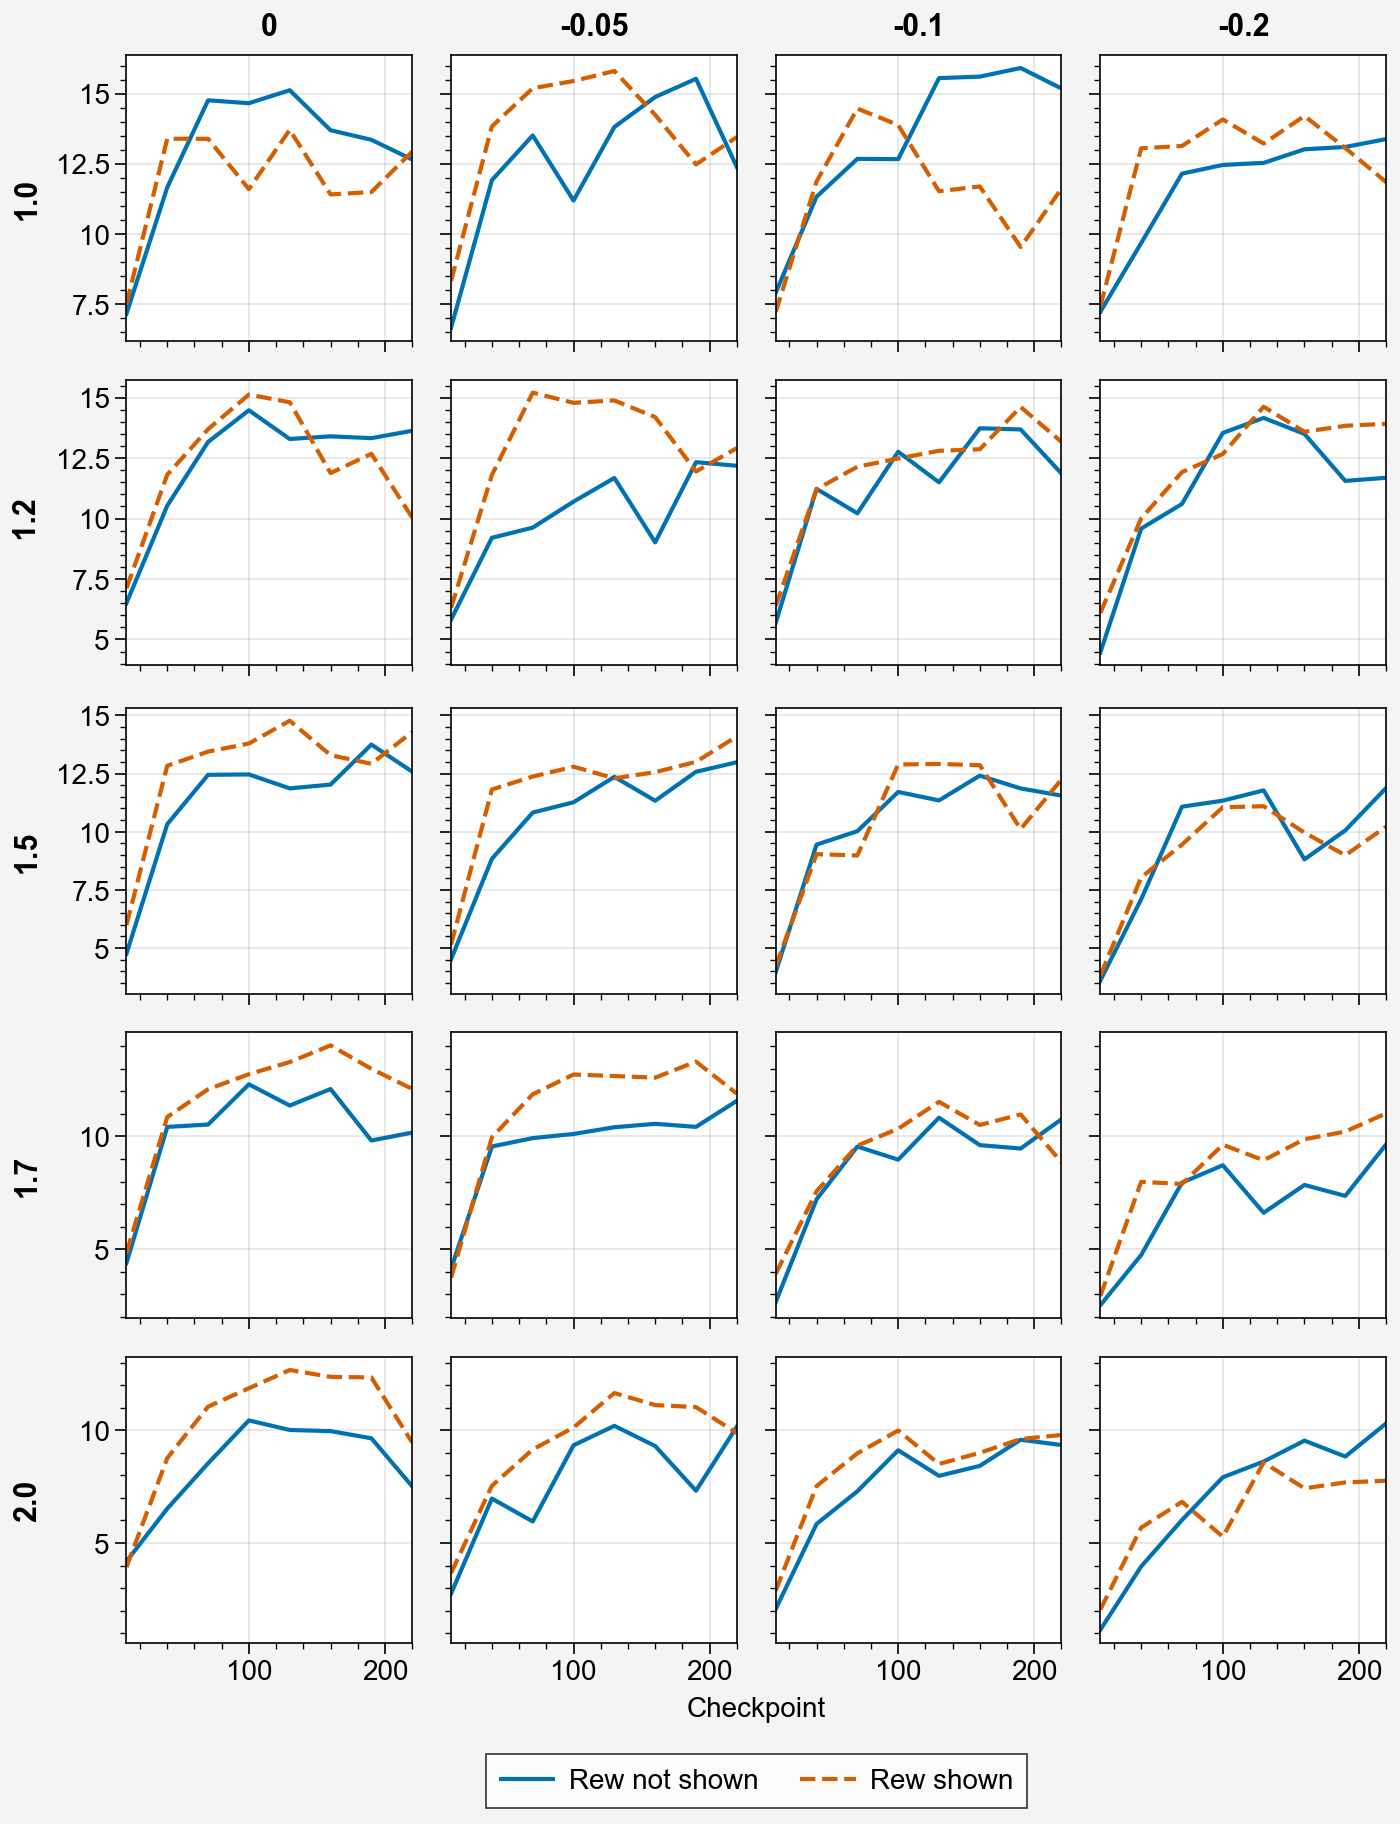

In [68]:
# True rewards

all_rew = res['rewards']
all_lens = res['all_lens']
all_pops = res['pop_rate']
all_num_balloons = res['all_num_balloons']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = pop_rates[:, i, j].mean(axis=(1, 3))
        lines = []
        pun = pop_vals[i]
        p = models[j]
        for h in range(2):
            r = (all_rew[h, i, j]**p).sum(axis=3)
            pop = pop_rates[h, i, j]*all_num_balloons[h, i, j]
            true_r = r + pop*pun
            true_r = true_r.mean(axis=(0, 2))
            ls = '-' if h == 0 else '--'
            lines.append(ax[j, i].plot(chks, true_r, label=give_labels[h],
                                       ls=ls))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels)
        

## Pushed sizes

The sizes that agents push balloons to regardless of whether the balloon popped or not

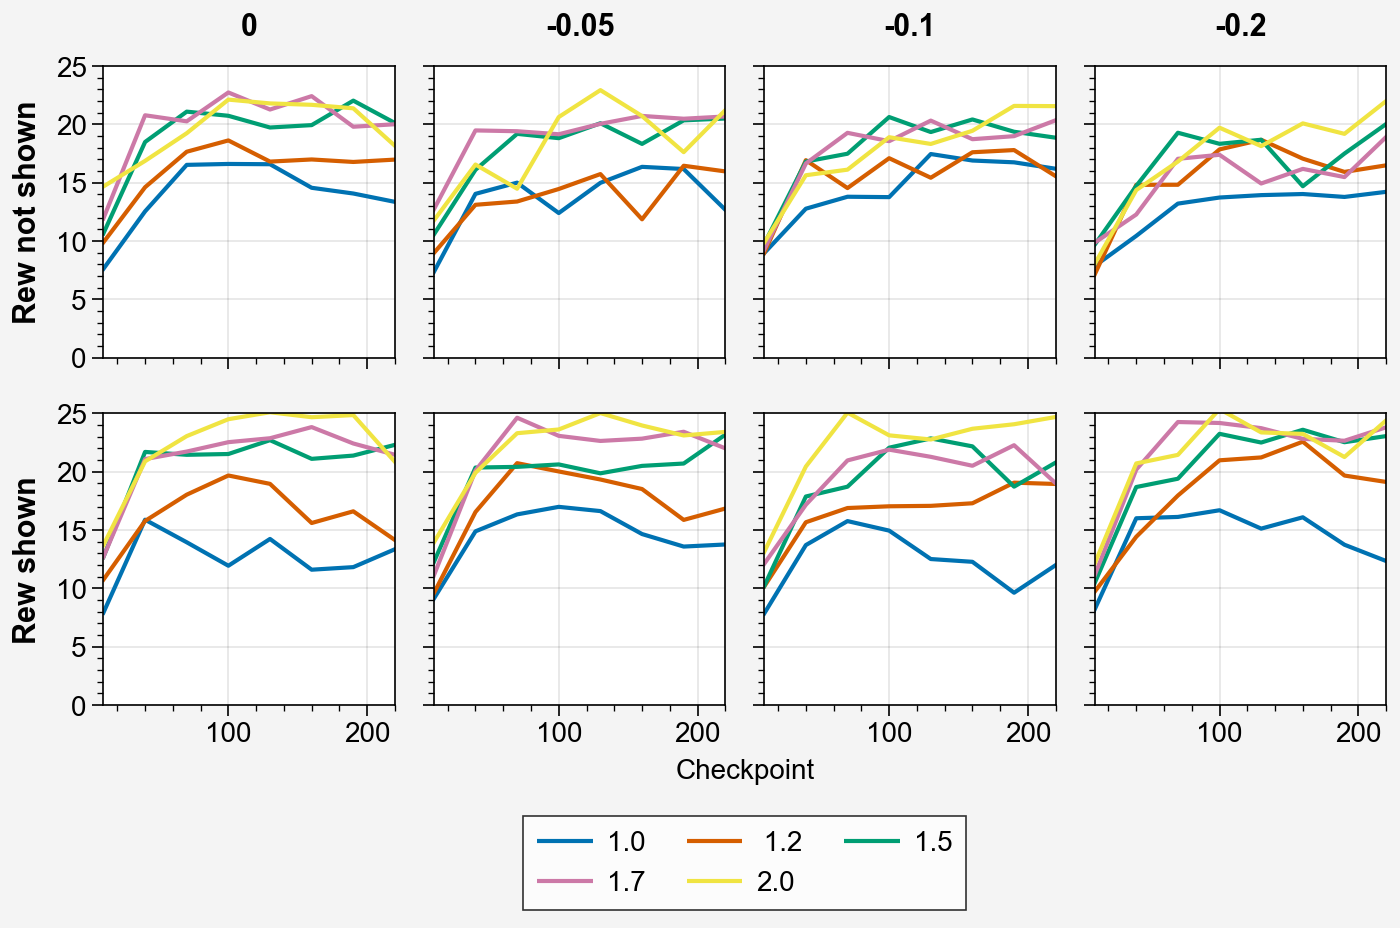

In [121]:
# True rewards

unpopped_sizes = res['unpopped_sizes']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=7)

for h in range(len(give_labels)):
    for i in range(len(pop_labels)):
        r = unpopped_sizes[h, i].sum(axis=4).mean(axis=(1, 3))
        lines = ax[h, i].plot(chks, r.T, label=p_labels)
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=give_labels,
          ylim=[0, 25])
        

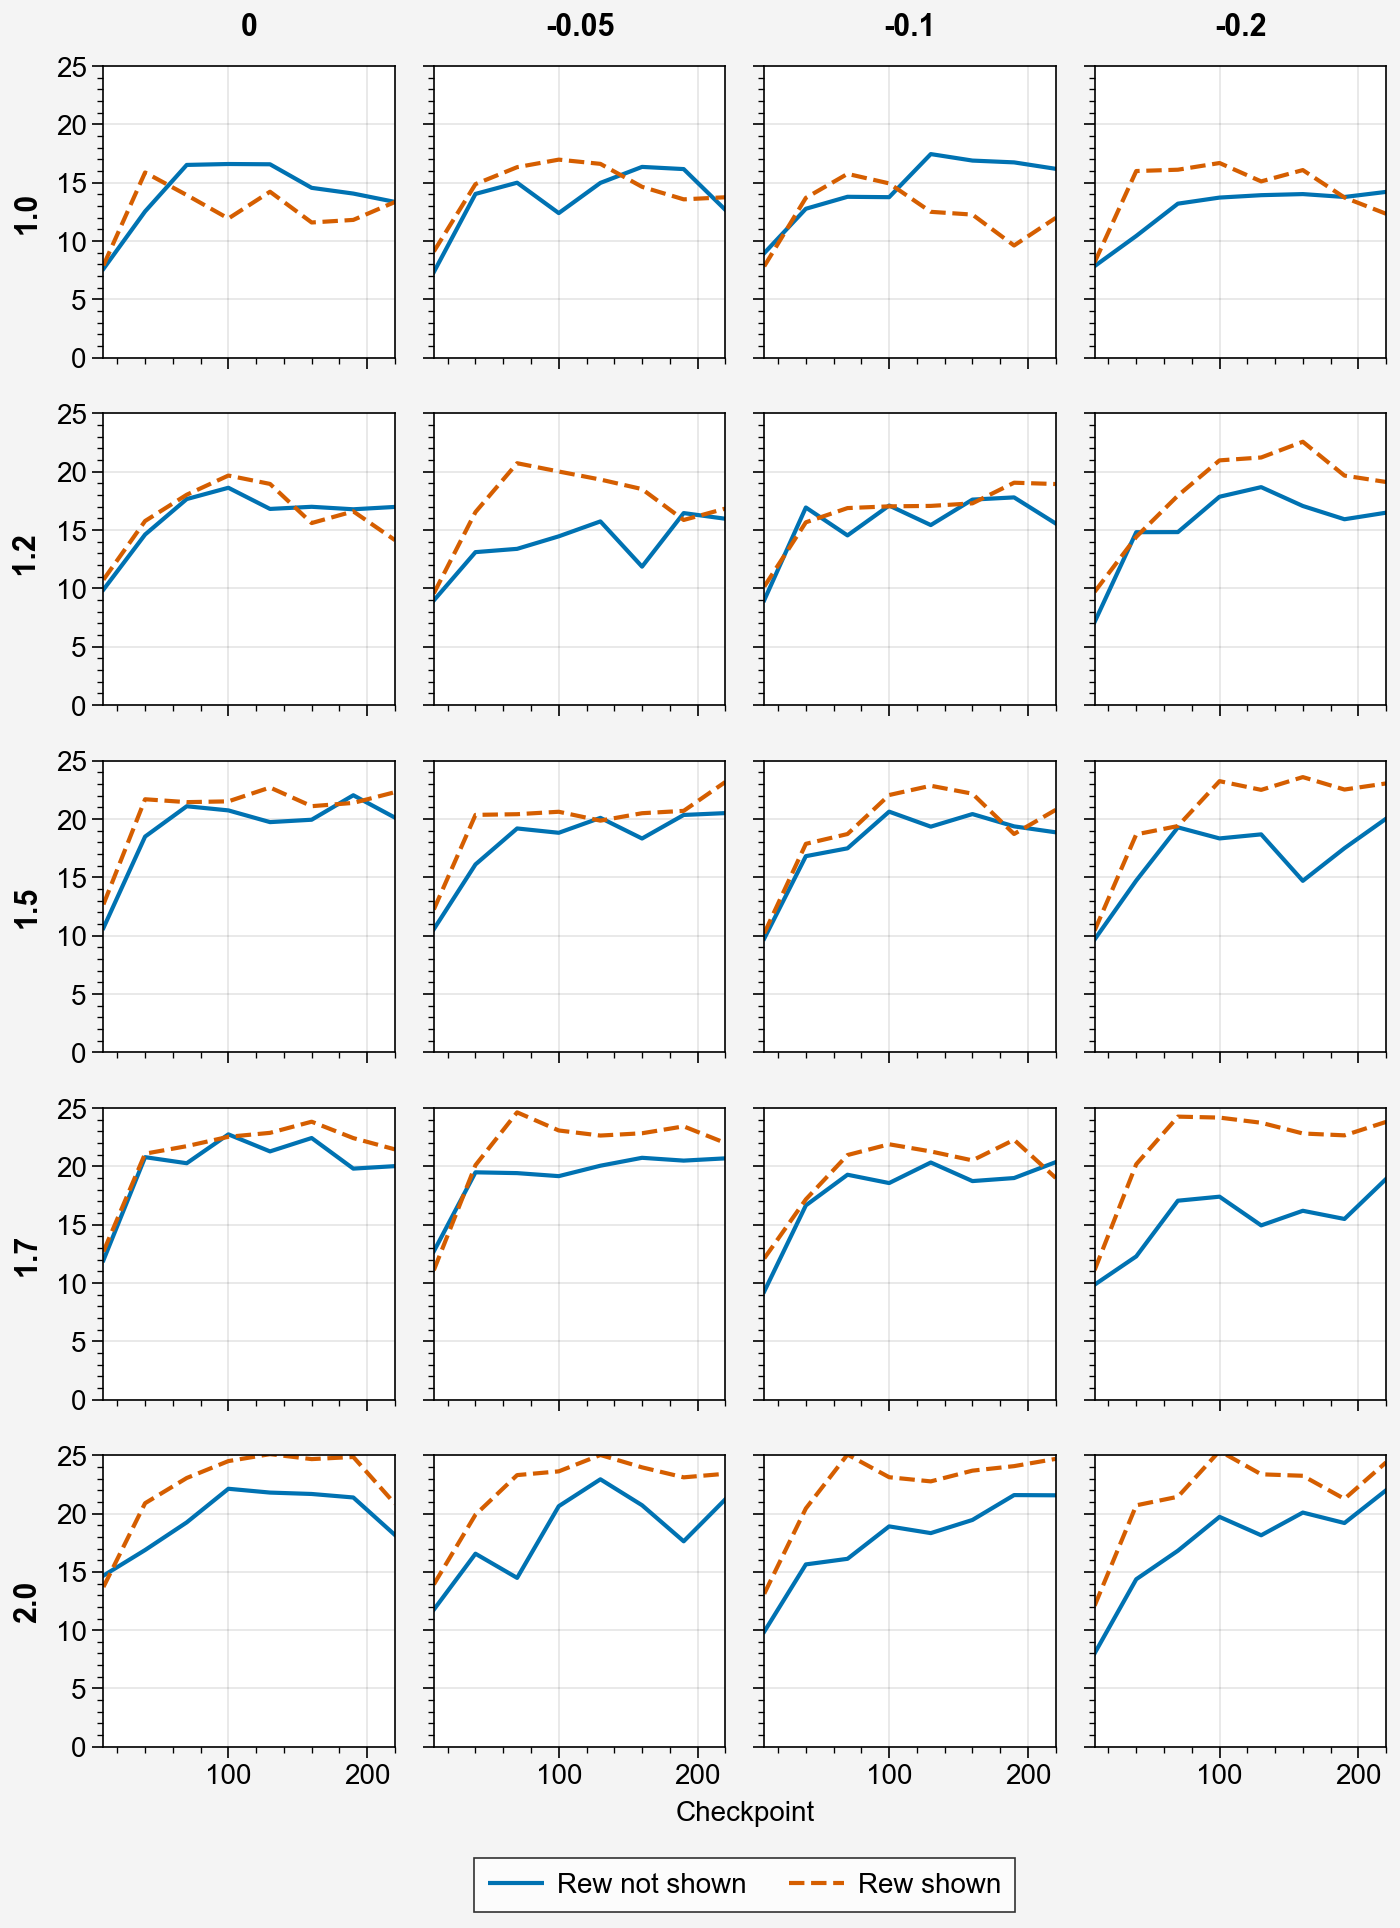

In [120]:
# True rewards

all_unpopped = res['unpopped_sizes']
all_lens = res['all_lens']

fig, ax = pplt.subplots(nrows=5, ncols=4, figwidth=7)

for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = all_unpopped[:, i, j].sum(axis=4).mean(axis=(1, 3))
        lines = []
        lines.append(ax[j, i].plot(chks, r[0], label=give_labels[0]))
        lines.append(ax[j, i].plot(chks, r[1], label=give_labels[1],
                                   ls='--'))
        
fig.legend(lines, loc='b')
ax.format(xlabel=chk_axis, toplabels=pop_labels, leftlabels=p_labels, 
          ylim=[0, 25])
        

# Find first performant checkpoint for each agent

Pretty clearly here, we can see that despite the agents achieving less true reward (the $r=s^p$ adjusted rewards with pops included) as p is increased, they achieve the same or more banked balloon rewards

If we want to find the agents that just pass a minimum score without worrying more about further skill, we can look for agents with a total >275 banked balloon size across thhe 17 episodes, which 90% of agents tested achieve at some point in the tested checkpoints

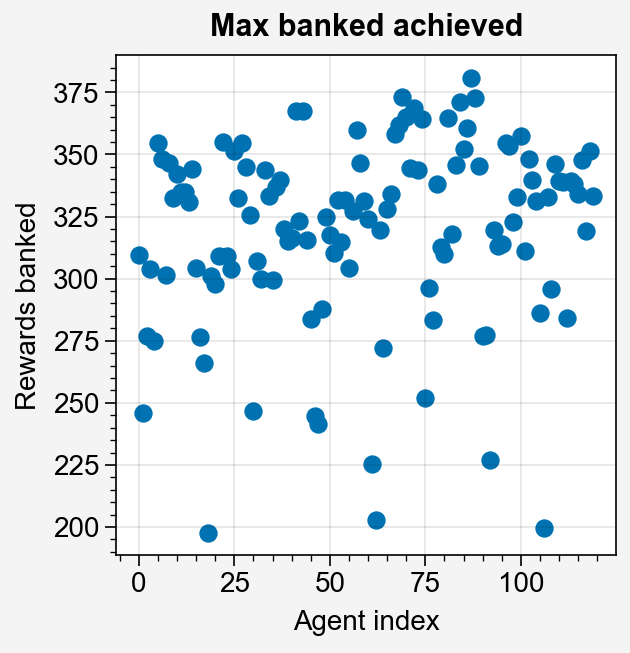

In [117]:
rew = res['rewards'].sum(axis=-1)
rew = rew.sum(axis=-1)
fig, ax = pplt.subplots()
ax.scatter(rew.max(axis=-1).reshape(-1))
ax.format(xlabel='Agent index', ylabel='Rewards banked', suptitle='Max banked achieved')

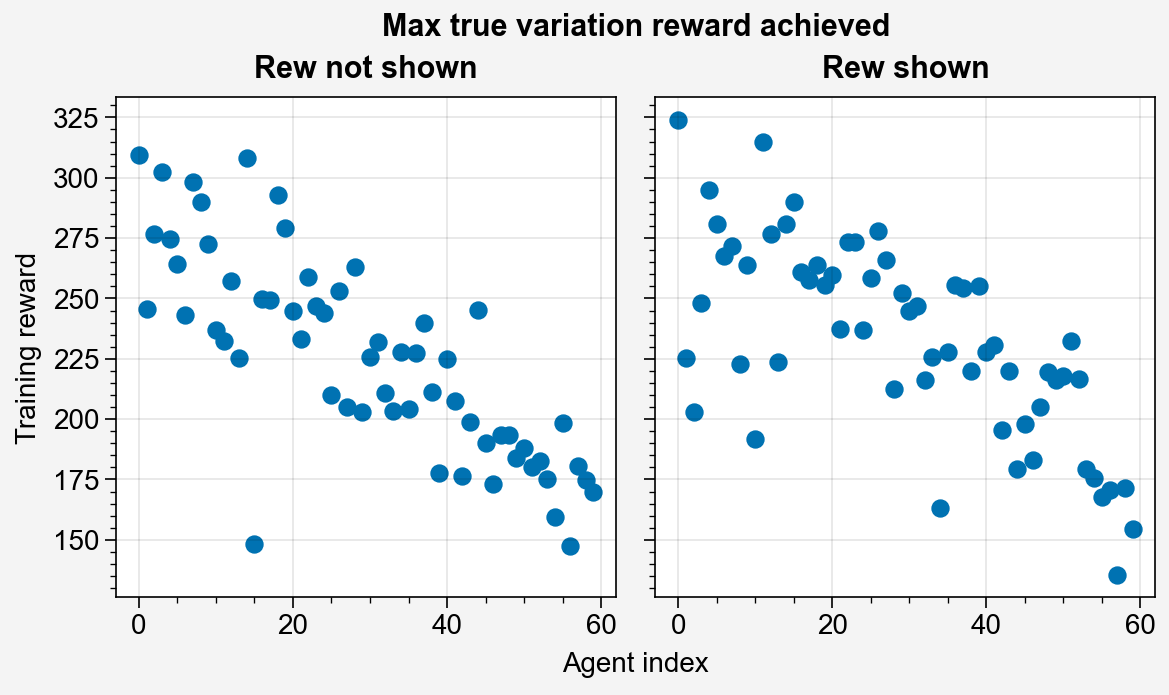

In [118]:
max_true_r = [[], []]
for j in range(len(p_labels)):
    for i in range(len(pop_labels)):
        r = pop_rates[:, i, j].mean(axis=(1, 3))
        lines = []
        pun = pop_vals[i]
        p = models[j]
        for h in range(2):
            r = (all_rew[h, i, j]**p).sum(axis=3)
            pop = pop_rates[h, i, j]*all_num_balloons[h, i, j]
            true_r = r + pop*pun
            true_r = true_r.sum(axis=-1)
            max_true_r[h].append(true_r.max(axis=1))
            
max_true_r = [np.concatenate(r) for r in max_true_r]
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    ax[h].scatter(max_true_r[h])

ax.format(xlabel='Agent index', toplabels=give_labels, ylabel='Training reward',
          suptitle='Max true variation reward achieved')

In [46]:
rewsum = all_rew.sum(axis=(5, 6))
bestrew = rewsum.max(axis=-1).flatten()
print((bestrew > 275).sum() / len(bestrew))

0.9
